## Image Captioning
- Generating Captions for Images

## Steps
- Data Collection
- Understanding the data
- Data Cleaning
- Loading the training set
- Data Preprocessing--Images
- Data Preprocessing--Captions
- Data Preperation using Generator function
- Word Embeddings
- Model Architecture
- Inference
- Evaluation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50,preprocess_input,decode_predictions
from keras.preprocessing import image
from keras.models import Model,load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input,Dense,Dropout,Embedding,LSTM
from keras.layers.merge import add

Using TensorFlow backend.


In [2]:
# Read text captions
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [3]:
captions = readTextFile("C:/Users/hp/Datasets/Flicker8K/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split("\n")[:-1] #splitting the data over the new line characters to ensure that in each line we have only one caption,and discarding the last line of the captions as it is an empty string 
len(captions) # counting the number of new lines,which will basically tell us hom many captions do we have

40460

In [4]:
captions[1]

'1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .'

##### Dictionary to map each image with the list of captions it has :


In [5]:
# to get the caption and the image id seprately we can split over the character "\t" as follows
#captions[0].split("\t")

# to get just the image id
f,s = captions[0].split('\t')
img_id = f.split('.')[0]
print(img_id)
print(s)

1000268201_693b08cb0e
A child in a pink dress is climbing up a set of stairs in an entry way .


In [6]:
descriptions = {}
for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    # if the image name not present then initialize it with an empty list
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    # else if description name is already present then append the caption to its respective list
    descriptions[img_name].append(second)

In [7]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

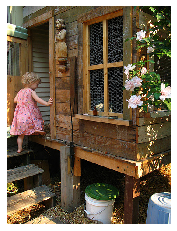

In [8]:
# Reading a single image
IMG_PATH = "C:/Users/hp/Datasets/Flicker8K/Flickr_Data/Flickr_Data/Images/" 

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

### Data Cleaning

In [9]:
def clean_text(sentence):
    sentence = sentence.lower() # lower case all the alphabets in the sentence
    sentence = re.sub("[^a-z]+"," ",sentence) # replacing any character which is not an alpahbet with space
    sentence = sentence.split()
    
    #sentence = [s for s in sentence if len(s)>1] #removing words of length 1
    sentence = " ".join(sentence)
    return sentence
    
    

In [10]:
clean_text("A cat is sitting over the house number 64")

'a cat is sitting over the house number'

In [11]:
# clean all coptions ie call clean_text function over the whole dictionary
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])
        

In [12]:
descriptions["1000268201_693b08cb0e"]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

In [13]:
# Write all the cleaned data into a text file
#with open("descriptions.txt","w") as f:
#    f.write(str(descriptions))

### Creating Vocabulary

In [14]:
descriptions = None
with open("descriptions.txt","r") as f:
    descriptions = f.read()

# we will be using a library that interprets it as a json file and converts it into a python dictionary
json_acceptable_string = descriptions.replace("'","\"") # this step is done to prevent json decodde error
descriptions = json.loads(json_acceptable_string)



In [15]:
print(type(descriptions))

<class 'dict'>


In [16]:
# create vocab

vocab = set()
for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]] # used list comprehension,although simple loop could also be used
      
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8441


In [17]:
#v = set()
#v.update(["hello","hi"])
#v.update(["apple","orange"])
#v.update(["apple","orange","mango"])
#v.update(["peach"])
#print(v)

In [18]:
# Total Number of words across all the sentences
total_words=[]
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
print("Total Words %d" %len(total_words))

Total Words 437466


In [19]:
print(total_words[:10])

['a', 'child', 'in', 'a', 'pink', 'dress', 'is', 'climbing', 'up', 'a']


In [20]:
# Filter words from the vocab accoridng to certain threshold frequency

In [21]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(freq_cnt)
print(len(freq_cnt))

{'a': 62995, 'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14

In [22]:
# Sort the dictionary according to the frequency count

# for ex. x=["way":53], since we want the sorting to happen accorind to the second value of this list ie accoridng to index 1 of the list 
# so we do lambda x:x[1]
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1]) # using sorted() function of python, and since we want the sorting to occur in reverse order so reverse=True 
# in above sorted() function we did freq_cnt.items, that's because freq_cnt is a dictionary and sorted() function don't works on a dictionary,therefore to use the sorted() function we use items inside the dictioanry not the dictionary itself.


# Filter
threshold=10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [23]:
print(len(total_words))
print(total_words)

1850
['a', 'in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman', 'girl', 'to', 'wearing', 'at', 'people', 'water', 'red', 'young', 'brown', 'an', 'his', 'blue', 'dogs', 'running', 'through', 'playing', 'while', 'shirt', 'down', 'standing', 'ball', 'little', 'grass', 'snow', 'child', 'person', 'jumping', 'over', 'three', 'front', 'sitting', 'holding', 'up', 'field', 'small', 'by', 'large', 'green', 'one', 'group', 'yellow', 'her', 'walking', 'children', 'men', 'into', 'air', 'beach', 'near', 'mouth', 'jumps', 'another', 'for', 'street', 'runs', 'its', 'from', 'riding', 'stands', 'as', 'bike', 'girls', 'outside', 'other', 'off', 'out', 'rock', 'next', 'play', 'orange', 'looking', 'pink', 'player', 'camera', 'their', 'pool', 'hat', 'jacket', 'boys', 'women', 'around', 'behind', 'some', 'background', 'dirt', 'toy', 'soccer', 'sits', 'dressed', 'has', 'wall', 'mountain', 'walks', 'crowd', 'along', 'plays', 'stand', 'looks', 'building', '

### Prepare Train/Test Data

In [24]:
train_file_data = readTextFile("C:/Users/hp/Datasets/Flicker8K/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("C:/Users/hp/Datasets/Flicker8K/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [25]:
#train_file_data[-1]
test_file_data[-1]
# since last image id is nothing just next line character so we will slice it out

'\n'

In [26]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]

In [27]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [28]:
# Prepare descriptions for the training data
# Tweak - Add <s> and <e> tokens to our training data <s>->start token <e>->end token

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [29]:
train_descriptions["1000268201_693b08cb0e"]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

# Transfer Learning
- images --> Features ,ie how we can use transfer learning to extract features from the images
- Text --> Features , ie how we can use transfer learning to extract features from the Text

### Step -1 Image Feature Extraction

there are to ways to use transfer learning ie using pretrained-model and using feature extraction, but for our project we will be using pretrained model.WE will use Resnet-50 model for our project that is already trained on the Imagenet Data

In [30]:
model  = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [31]:
#model.layers[-2]
#model.layers[-2].output

In [32]:
model_new = Model(model.input,model.layers[-2].output)

In [33]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

In [34]:
# checking a single preprocessed image that wil be fed to the resnet-50 model 
#img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#plt.axis("off")
#plt.show()

In [35]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,)) # reshaping it to single simension, instead of reshape(-1,) we could also write like reshape(2048, ))           
    #print(feature_vector.shape)
    return feature_vector

In [36]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.04154298, 0.17076086, 0.29278618, ..., 0.05089604, 0.31322357,
       0.8600744 ], dtype=float32)

In [37]:
start_time = time()
encoding_train = {}
#image_id --> feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix % 100 == 0:
        print("Encoding in Progress Time step %d " %ix)
end_time = time()
print("Total Time Taken : ",end_time-start_time)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [38]:
# Store everything to the disk
#with open("encoded_train_features.pkl","wb") as f:
#    pickle.dump(encoding_train,f) # f is the file pointer where i want to dump my file
     

In [39]:
# Now similary encoding test images
start_t = time()
encoding_test = {}
#image_id --> feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix % 100 == 0:
        print(" Test Encoding in Progress Time step %d " %ix)
end_t = time()
print("Total Time Taken : ",end_t-start_t)

 Test Encoding in Progress Time step 0 
 Test Encoding in Progress Time step 100 
 Test Encoding in Progress Time step 200 
 Test Encoding in Progress Time step 300 
 Test Encoding in Progress Time step 400 
 Test Encoding in Progress Time step 500 
 Test Encoding in Progress Time step 600 
 Test Encoding in Progress Time step 700 
 Test Encoding in Progress Time step 800 
 Test Encoding in Progress Time step 900 
 Test Encoding in Progress Time step 1000 
 Test Encoding in Progress Time step 1100 
 Test Encoding in Progress Time step 1200 
 Test Encoding in Progress Time step 1300 
 Test Encoding in Progress Time step 1400 
 Test Encoding in Progress Time step 1500 
 Test Encoding in Progress Time step 1600 
 Test Encoding in Progress Time step 1700 
 Test Encoding in Progress Time step 1800 
 Test Encoding in Progress Time step 1900 
 Test Encoding in Progress Time step 2000 
 Test Encoding in Progress Time step 2100 
 Test Encoding in Progress Time step 2200 
 Test Encoding in Progr

In [40]:
# Store everything to the disk
#with open("encoded_test_features.pkl","wb") as f:
#    pickle.dump(encoding_test,f) # f is the file pointer where i want to dump my file
     

## Data Pre-processing for Captions

In [41]:
# Vocab
len(total_words)

1850

In [42]:
word_to_idx = {} # this dictionary maps words to their respective indexes
idx_to_word = {} # this dictionary maps indexes to their respective words

for i,word in enumerate(total_words):
    word_to_idx[word] =  i+1
    idx_to_word[i+1] = word
    
    

In [43]:
# word_to_idx["dog"]
#idx_to_word[7]
print(len(idx_to_word))

1850


In [44]:
# Adding two special words to the dictionary at the end of the vocab
idx_to_word[1851] = "startseq"
word_to_idx['startseq'] = 1851

idx_to_word[1852] = "endseq"
word_to_idx['endseq'] = 1852

vocab_size = len(word_to_idx)+1
print("Vocab Size",vocab_size)


Vocab Size 1853


In [45]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
print(max_len)

38


## Constructing Data Loader(Generator)

In [46]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2,y = [],[],[]
    
    n = 0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1 
            
            photo = encoding_train[key]
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    # 0 denotes padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0] # xi is a 2d-matrix , padding type is post which means we are adding this padding after the sequence of numbers
                    yi = to_categorical([yi],num_classes = vocab_size)[0] # we know that when we are making neural network we need to convert yi into one hot vectors
                    
                    X1.append(photo) # photo is a 2048 dimensional vector
                    X2.append(xi) # in X2 as of now we are storing a 35 dimensional vector, later on we will convert it into a glove embedding
                    y.append(yi) # in y we stor a one hot vector , which is equal to vocab size which is approximately 1800
                if n == batch_size:
                    yield[[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0
                     
                

### Word Embeddings 

In [47]:
f = open("C:/Users/hp/Datasets/glove.6B.50d.txt",encoding='utf8')

In [48]:
embedding_index = {} # it is a dictionary that stores the embedding vectors as values for the corresponding words as keys of the dictionary

for line in f:
    values = line.split()
    #print(values)
    word = values[0]
    word_embedding = np.array(values[1:],dtype='float')
    embedding_index[word] = word_embedding

In [49]:
f.close()

In [50]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [51]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim)) # initialize embedding vectors for all words in vocab with all 0's
    for word,idx in word_to_idx.items(): # searching for the embedding vectors of only those words which are present in the vocab
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix

In [52]:
#word_to_idx['the']

In [53]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1853, 50)

In [54]:
#embedding_matrix[1852] # because at index 1852 we have 'endseq' in vocab which is not present inthe glove vector, so we got a vector with all 0's for endseq 

### Model Architecture

In [55]:
# Image Feature Extraction Model(Processing images)
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [56]:
# Partial Caption Sequence Model(Captions as Input)
# Processing captions
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim = vocab_size,output_dim = 50,mask_zero = True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2) # 256 is the size of the hidden vector that is passed from one side of the lstm cell to other


In [57]:
# decoder(feed-forward) model
decoder1 = add([inp_img2,inp_cap3]) # where inp_img2 is the processed image and and the inp_cap3 is the processed caption
# remember that inp3 captures the entire sentence that you have generated till now
# decoder1 adds two tensors of same dimension ie of 256 dimension

decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs = [input_img_features,input_captions],outputs = outputs)

In [58]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 38)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 38, 50)       92650       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [59]:
# Important hting,Embedding Layer:- initializing the embedding weights with the embedding matrix we made above   
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False # w don't want to train our embedding layer as the model is being trained as we have already initialized our embedding weights with the pretrained-weights

In [60]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

### Training Of Model

In [61]:
# Here we will be using the generator we made earlier
epochs = 20
batch_size = 3
steps = len(train_descriptions)//batch_size

In [62]:
for i in range(epochs):
    generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
    model.fit_generator(generator,epochs=1,steps_per_epoch = steps,verbose=1) # in this line , epochs=1 indicates that how many times you want your batch to pass through the current epoch that we have given as 1 
    model.save('./model_weights/model_'+str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 424s 212ms/step - loss: 3.8539
Epoch 1/1
2000/2000 [==============================] - 419s 209ms/step - loss: 3.1702
Epoch 1/1
2000/2000 [==============================] - 434s 217ms/step - loss: 2.9390
Epoch 1/1
2000/2000 [==============================] - 418s 209ms/step - loss: 2.7969
Epoch 1/1
2000/2000 [==============================] - 415s 208ms/step - loss: 2.6933
Epoch 1/1
2000/2000 [==============================] - 377s 189ms/step - loss: 2.6187
Epoch 1/1
2000/2000 [==============================] - 1152s 576ms/step - loss: 2.5558
Epoch 1/1
2000/2000 [==============================] - 422s 211ms/step - loss: 2.5065
Epoch 1/1
2000/2000 [==============================] - 378s 189ms/step - loss: 2.4648
Epoch 1/1
2000/2000 [==============================] - 1558s 779ms/step - loss: 2.4301
Epoch 1/1
2000/2000 [==============================] - 579s 289ms/step - loss: 2.3988
Epoch 1/1
2000/2000 [==============================]

In [63]:
model = load_model('./model_weights/model_9.h5')

## Predictions

In [71]:
def predict_caption(photo):
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen = max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() # take the word with maximum probability always-this type of sampling is also known as Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == 'endseq':
            break
    # Final caption will be the in_text after removing 'startseq' and 'endseq'
    final_caption = in_text.split()[1:-1] # removing staring word that is startseq and the ending word that os endseq
    final_caption = ' '.join(final_caption)
    
    return final_caption

### Pick some random images and see results

a group of people are standing on a beach


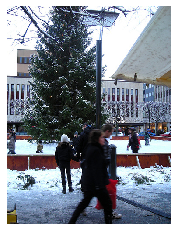

a little girl in a red shirt is playing in the sprinklers


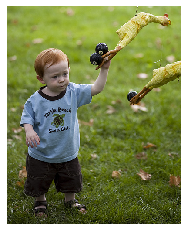

a brown dog is running on the beach


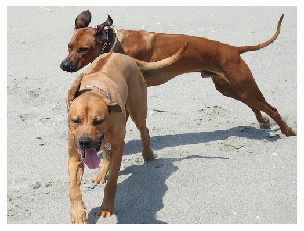

a man in a black shirt and a black headband is playing a guitar


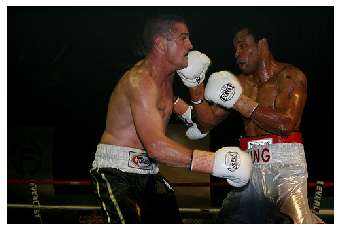

a boy in a red shirt is riding a go go round


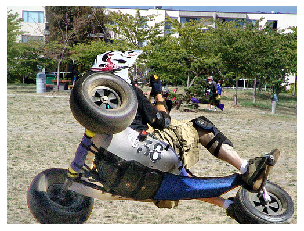

a baby in a green shirt is sitting on a bed with a green towel


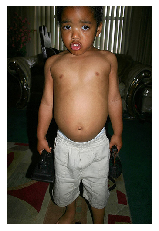

a skier descends a snowy trail


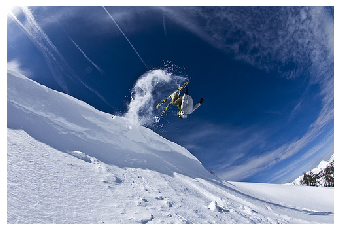

a man in a black shirt is sitting on a chair with a drink


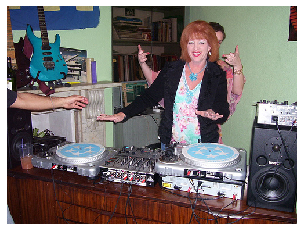

a man in a red helmet is riding a bicycle in a race


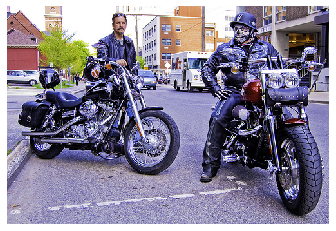

a man in a black shirt and a jean hat is smiling


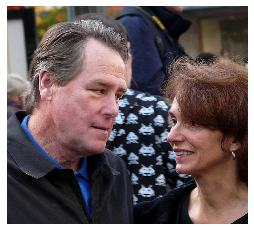

a girl in a pink shirt is sitting on a park bench


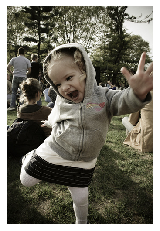

a small dog is eating a


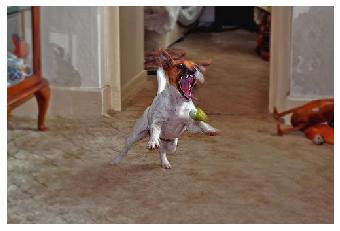

a dog is jumping over a pile of water


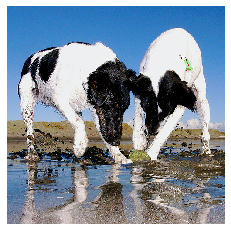

a man in a red jacket is standing in front of a white building


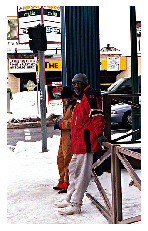

a brown dog is running through the grass


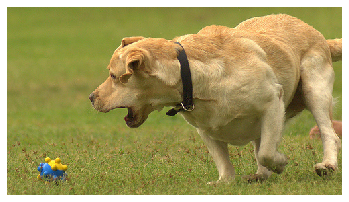

In [72]:
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048)) # 1 represents the natch size, ie the batch size is 1,that means we are generating predictions for one image at a time
    
    i = plt.imread("C:/Users/hp/Datasets/Flicker8K/Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    caption = predict_caption(photo_2048)
    print(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()